In [ ]:
import dotenv

dotenv.load_dotenv()

True

In [15]:
from langchain import PromptTemplate
from langchain.schema import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI

/home/naman/miniconda3/envs/langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType

In [17]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [79]:
from langchain.tools import BaseTool
from typing import Union
import os
import requests


class HotelData(BaseTool):
    name: str = "Hotel data collector"
    description: str = (
        "use this tool when you need the information about the hotel at destination place"
    )

    def _run(self, source: str, destination: str, from_date: str, to_date: str) -> str:
        url = "https://booking-com15.p.rapidapi.com/api/v1/hotels/searchDestination"

        querystring = {"query": "Goa"}

        headers = {
            "x-rapidapi-key": os.environ.get("RAPID_API_KEY"),
            "x-rapidapi-host": "booking-com15.p.rapidapi.com",
        }

        response = requests.get(url, headers=headers, params=querystring).json()
        geoid = response["data"][0]["dest_id"]

        url = "https://booking-com15.p.rapidapi.com/api/v1/hotels/searchHotels"

        querystring = {
            "dest_id": f"{geoid}",
            "search_type": "CITY",
            "arrival_date": "2025-02-20",
            "departure_date": "2025-02-25",
            "currency_code": "INR",
        }

        response = requests.get(url, headers=headers, params=querystring).json()
        hotels = []
        for i in response["data"]["hotels"]:
            hotels.append(i["property"]["name"])
        return {"Hotels": hotels}

    def _arun(self, radius: int):
        raise NotImplementedError("This tool does not support async")

In [80]:
import requests
import os

In [81]:
tools = [load_tools(["serpapi"])[0], HotelData()]

In [82]:
tools[0].description = (
    "A search engine. Useful when you need to find information about anything. Use this to find popular attractions, landmarks, and activities at the destination. Input should be a search query."
)

In [83]:
agent = initialize_agent(
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method="generate",
)

In [58]:
agent.run("Can you tell me flight from bombay to goa on 24 feb 2025 to 28 feb 2025 ?")



> Entering new AgentExecutor chain...
Thought:
I can use the Flight and Hotel data collector tool to get this information.

Action:
```json
{
  "action": "Flight and Hotel data collector",
  "action_input": {
    "source": "bombay",
    "destination": "goa",
    "from_date": "24 feb 2025",
    "to_date": "28 feb 2025"
  }
}
```

KeyboardInterrupt: 

In [18]:
a = agent.agent.llm_chain.prompt.messages[0].prompt.template
print(a)

Respond to the human as helpfully and accurately as possible. You have access to the following tools:

Search: A search engine. Useful when you need to find information about anything. Use this to find popular attractions, landmarks, and activities at the destination. Input should be a search query., args: {{'tool_input': {{'type': 'string'}}}}
Flight and Hotel data collector: use this tool when you need the information about the flight and hotel from source to destination, args: {{'source': {{'title': 'Source', 'type': 'string'}}, 'destination': {{'title': 'Destination', 'type': 'string'}}, 'from_date': {{'title': 'From Date', 'type': 'string'}}, 'to_date': {{'title': 'To Date', 'type': 'string'}}}}

Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or Search, Flight and Hotel data collector

Provide only ONE action per $JSON_BLOB, as shown:

```
{{
  "action": $TOOL_NAME,
  "action_inp

In [84]:
with open("prompt.txt", "r") as f:
    prompt = f.read()

In [85]:
agent.agent.llm_chain.prompt.messages[0].prompt.template = prompt

In [88]:
result = agent.run(
    "Plan a vacation for me from mumbai to goa starting from 24 feb 2025 to 28 feb 2025"
)



> Entering new AgentExecutor chain...
Thought:
I need to search for hotels and attractions in Goa for the specified dates.

Action:
```json
{
  "action": "Hotel data collector",
  "action_input": {
    "source": "mumbai",
    "destination": "goa",
    "from_date": "24 Feb 2025",
    "to_date": "28 Feb 2025"
  }
}
```
Observation: {'Hotels': ['Hacienda Isabela Hotel Campestre', 'Don David Sabana Hotel', 'Hotel restaurante Lisboa', 'Relajante Parcela Loma Linda, Cerro de la Aurora, Lebrija', 'Colina Real , Lebrija Santander']}
Thought:Thought:
The hotel data collector returned some unexpected results. It seems to have listed hotels that are not in Goa. I'll use the search tool to find hotels and attractions in Goa.

Action:
```json
{
  "action": "Search",
  "action_input": "hotels in Goa available from 24 Feb 2025 to 28 Feb 2025"
}
```

Observation: {'type': 'hotels'}
Thought:Thought:I need to search for attractions in Goa.
Action:
```json
{
  "action": "Search",
  "action_input": "pop

In [89]:
print(result)

Your Goa vacation plan from 24 Feb 2025 to 28 Feb 2025:

I couldn't retrieve specific hotel availability for your dates, but you can find hotels in Goa through online travel agencies like Booking.com, Expedia, MakeMyTrip, etc. Look for options in areas like Calangute, Baga, Panaji, or Candolim depending on your preference.

Here are some popular attractions in Goa:

* **Historical Sites:** Basilica of Bom Jesus, Se Cathedral, Immaculate Conception Church, Aguada Fort, Chapora Fort, Reis Magos Fort, Cabo de Rama Fort
* **Nature & Beaches:** Dudhsagar Falls, Palolem Beach, Baga Beach, Calangute Beach, Sinquerim Beach, Agonda Beach, Arambol Beach, Benaulim Beach, Candolim Beach Road
* **Religious Sites:** Shree Mangueshi Temple, Shree Shantadurga Temple
* **Nature Reserve:** Mollem National Park & Bhagwan Mahavir Wildlife Sanctuary

You can customize your itinerary based on your interests.  Enjoy your trip!


In [6]:
prompt = """You are a travel planning assistant. When a user provides travel dates and a destination,
your role is to gather information about available flight options for the specified dates and suggest popular attractions,
landmarks, and activities at the destination. Provide clear and organized details on flights, including options based on convenience and budget, and 
highlight must-visit places that enhance the travel experience.

Travel Dates: {dates}
Source: {source}
Destination: {destination}
Answer:"""

prompt_template = PromptTemplate.from_template(prompt)
print(prompt_template)

input_variables=['dates', 'destination', 'source'] template='You are a travel planning assistant. When a user provides travel dates and a destination,\nyour role is to gather information about available flight options for the specified dates and suggest popular attractions,\nlandmarks, and activities at the destination. Provide clear and organized details on flights, including options based on convenience and budget, and \nhighlight must-visit places that enhance the travel experience.\n\nTravel Dates: {dates}\nSource: {source}\nDestination: {destination}\nAnswer:'


* https://www.pinecone.io/learn/series/langchain/langchain-tools/
* https://www.kaggle.com/code/ilhansevval/build-custom-tools-using-agent-in-langchain

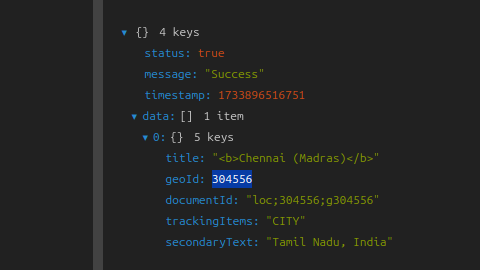 
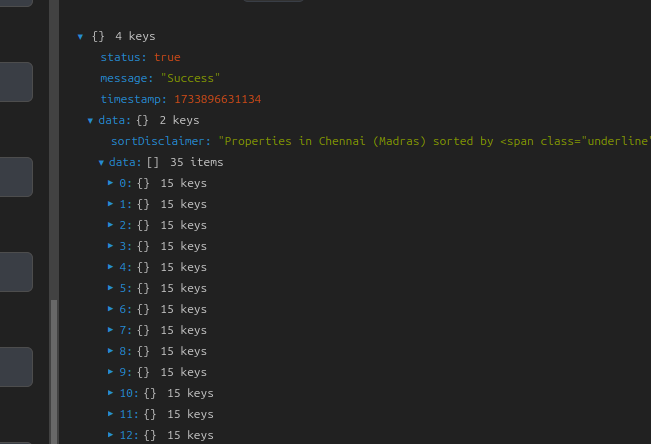